Subdivide the images of Covid + pneumonia into:
Train - validation - test sets.

Train PCA on the train set (keep 90% of info), generate component images.

Script of June 26th - July 3rd

See: module "dim reduction", intro lesson 1.

June 27th:load the images using OpenCV.

V4: appeler le chargement des images depuis une fonction.

_Résultat_: dans ce script, la fonction génère le DataFrame avec un ordre de lignes différent,
cela ne change pas le dessin, mais change le train-test split. Le score de la prédiction baisse de 0.87 à 0.68 (plus haut, que la random, amais en-dessous de la prédiction constante de la classe majoritaire == 0.74)!

Les performaces du modèle SVM varient entre 0.87, 0.68, 0.81 suite à des modifications aléatoires.

V5: charger les images par une  fonction spécifique.
_Résultat:_ le temps pour charger les images passe à 10 secondes.

PCA2_SVM : appliquer la séparation en 3 classes. Le score et les F1 sont de l'ordre de 0.67 à partir de 10000 époques.
Ce scode est identique à celui de CNN. On remarque cependant que la classe 1 (malade non-COVID) est relativement mieux séparée, alors que les deux autres se mélangent plus souvent.

In [1]:
# imports
import os

import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2

from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import classification_report

from train_val_test_split import train_val_test_split

from load_images_PCA1_v5 import unfold_except_1st_dim

image_path = '../data'

# Load data into a large tensor. 

Concatenate DataFrames using a single function call.
->

Reduce data to size 28*28, load to a tensor, NImages x 28 x 28,

TOADAPT from 'CNN_28x28_1layer.ipynb' .

In [2]:
# Hyperparamètres (réduction de l'image)
IMG_HEIGHT = 28
IMG_WIDTH = 28

# L'architecture du CNN peut aussi être déplacée ici.

In [3]:
def list_img(image_dir: str, sought_ext='.png'):
    """
    List of files with a specific extension in a folder.

    Useful for extracting the number of files.
    Can also be used as the first step of the next version of function 'load_images'.

    Args:
        image_dir (str): path to folder
        sought_ext (str, optional): sought extension. Defaults to '.png'.

    Returns:
        list of str: the list of image files in the order of os.listdir.
    """
    files = os.listdir(image_dir)
    lst_images = [file_name for file_name in files if file_name.endswith(sought_ext)]
    return lst_images

In [4]:
def load_images(image_dir, label, limit=None, random_state=None):
    """
    Fonction pour charger les images d'un dossier.
    
    Args:
        image_dir (str): path to folder
        label (str or int): the label to associate to the images
        limit (int, optional): the max number of files to load.
            Defaults to None (load all PNG images).

    Constants imported from higher level: 
        IMG_HEIGHT, IMG_WIDTH

    Called by the function: load_data.

    Returns:
        tensor NImages x HEIGHT x WIDTH x 1: the images resized to HEIGHT x WIDTH;
        1d array (NImages,) : the label expanded to array.
    
    Possible improvements.
    1. Speed up the function by preallocating the tensor first,
    then writing into it.

    4. Return the  filenames of the extracted images as a 3rd output.
    """
    image_data = []
    label_data = []
    rng = np.random.default_rng(seed=random_state)

    all_files = list_img(image_dir)
    
    if limit:
        files = rng.choice(all_files, size=limit, replace=False)
        
    for file_name in files:
        img_path = os.path.join(image_dir, file_name)
        try:
            # Read the grayscale image as: HEIGHT x WIDTH x 1
            
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = np.expand_dims(img, axis=-1)
            
            img = img / 255.0
            image_data.append(img)
            label_data.append(label)
        except Exception as e:
            print(f"Erreur de chargement de l'image {file_name} : {e}")
    
    return np.array(image_data), np.array(label_data)

In [5]:
def load_data(image_dirs, labels, limits=None, random_state=None):
    """
    Load data from several folders

    Args:
        image_dirs (list of 'str'): the paths to folders.
        labels (list of 'str' of the same length): _description_
        limits (list if int of None, optional): the number of files to load.
            Defaults to None.

    Returns:
        tensor sum_{folders}(NImages) x HEIGHT x WIDTH :
            the images resized to HEIGHT x WIDTH;
        1d array (sum_{folders}(NImages),) : the labels expanded to array.
    """
    all_images = []
    all_labels = []
    
    limits2 = [None] * len(image_dirs) if limits is None else limits
    
    for i, image_dir in enumerate(image_dirs):
        images, label_data = load_images(image_dir,
                                        labels[i],
                                        limits2[i],
                                        random_state=random_state)
        all_images.append(images)
        all_labels.append(label_data)
    return np.concatenate(all_images), np.concatenate(all_labels)

In [6]:
def cond2folder(condition):
    return os.path.join(image_path, condition, "images")

Charger les images: 2500 COVID, (1250 Pneumo + 1250 Opacity), 2500 normaux choisies aléatoirement 

In [7]:
lst_conditions = ['COVID', 'Viral Pneumonia', 'Lung_Opacity', 'Normal']
lst_dirs = list(map(cond2folder, lst_conditions))
print(lst_dirs)

lst_labels = [2, 1, 1, 0]

print("labels:", lst_labels)

# determine the number of images to load
# num_COVID_img = len(list_img(lst_dirs[0]))
lst_nums_images = list(map(lambda path_dir: len(list_img(path_dir)), lst_dirs ))
print("Total number of images for each condition:", lst_nums_images)
# [3616, 6012, 1345]


['../data/COVID/images', '../data/Viral Pneumonia/images', '../data/Lung_Opacity/images', '../data/Normal/images']
labels: [2, 1, 1, 0]
Total number of images for each condition: [3616, 1345, 6012, 10192]


In [8]:
# Number of images to extract:
num_img_COV = 2500

balanced_lst_nums_images = [num_img_COV, num_img_COV//2, num_img_COV//2, num_img_COV]

print(balanced_lst_nums_images)
# [3616 2955 661] # -> ...


[2500, 1250, 1250, 2500]


Extract images.

In [9]:
start = time.time()
# data, labels = load_data(lst_dirs, lst_labels, balanced_lst_nums_images)
data, labels = load_data(lst_dirs,
                        lst_labels,
                        balanced_lst_nums_images,
                        random_state=42)
done = time.time()

elapsed = done - start
print(f'Loading data : {elapsed:.2f} sec \n\n')
# 7 sec

print(type(data))  # ndarray
print(data.shape)  # (7232, 28, 28, 1)

print(type(labels))  # ndarray
print(labels.shape)  # (7232,)

Loading data : 7.00 sec 


<class 'numpy.ndarray'>
(7500, 28, 28, 1)
<class 'numpy.ndarray'>
(7500,)


Loading data from tensor to DF

In [10]:
data_mat = unfold_except_1st_dim(data)
var_target = 'group'

df = pd.DataFrame(data=data_mat)
df[var_target] = labels

print(df.shape)   # (7500, 785 == 28*28 + 1) 
print(df.info())

df.head()

(7500, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Columns: 785 entries, 0 to group
dtypes: float64(784), int64(1)
memory usage: 44.9 MB
None


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,group
0,0.443137,0.443137,0.494118,0.486275,0.450980,0.478431,0.513725,0.549020,0.549020,0.509804,...,0.603922,0.584314,0.560784,0.545098,0.525490,0.505882,0.462745,0.376471,0.227451,2
1,0.105882,0.109804,0.109804,0.109804,0.109804,0.109804,0.101961,0.133333,0.137255,0.137255,...,0.749020,0.717647,0.635294,0.113725,0.152941,0.192157,0.160784,0.172549,0.188235,2
2,0.231373,0.168627,0.070588,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.980392,0.968627,0.941176,0.890196,0.831373,0.737255,0.611765,0.443137,0.058824,2
3,0.011765,0.011765,0.007843,0.007843,0.003922,0.039216,0.066667,0.086275,0.125490,0.145098,...,0.960784,0.949020,0.941176,0.933333,0.917647,0.894118,0.854902,0.847059,0.745098,2
4,0.258824,0.211765,0.211765,0.282353,0.349020,0.384314,0.400000,0.403922,0.392157,0.431373,...,0.843137,0.831373,0.811765,0.788235,0.764706,0.749020,0.635294,0.501961,0.384314,2


# train-validation-test split

In [11]:
# separate features, target.
data = df.drop(var_target, axis=1)
target = df[var_target]

print(data.info())  # (7500, 784)
print('------')
print(type(target))  # Series
print(target.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Columns: 784 entries, 0 to 783
dtypes: float64(784)
memory usage: 44.9 MB
None
------
<class 'pandas.core.series.Series'>
(7500,)


In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(data,
                                                                    target,
                                                                    random_state=42)

print(X_train.shape)   # (5400, 784)
print(X_val.shape)     # (1350, 784)
print(X_test.shape)    # (750, 784)

(5400, 784)
(1350, 784)
(750, 784)


# train PCA on train set
Output: number of components for achieving 90% of info.

In [13]:
# (p)
pca90 = PCA(n_components=0.9)

start = time.time()
X_train_pca = pca90.fit_transform(X_train)
done = time.time()

elapsed = done - start
print(f'Time for training PCA = {elapsed:.2f} sec \n\n')

print(X_train_pca.shape)  # (5400, 47)

X_val_pca = pca90.transform(X_val)
print(X_val_pca.shape)  # (1350, 47)

# About 3 mins.

Time for training PCA = 0.76 sec 


(5400, 47)
(1350, 47)


PCA a réduit le nombre de colonnes de près de 90000 à 50.

# scatterplot of components 1, 2 colored according to their class

In [14]:
# (q)
def plt_scatter_dims12(data, colors):
    """
    Affiche les 2 premiéres colonnes d'une matrice.

    Args:
        data (_type_): _description_
        colors (_type_): _description_

    Returns:
        _type_: _description_
    """
    return plt.scatter(data[:, 0], data[:, 1], c=colors)

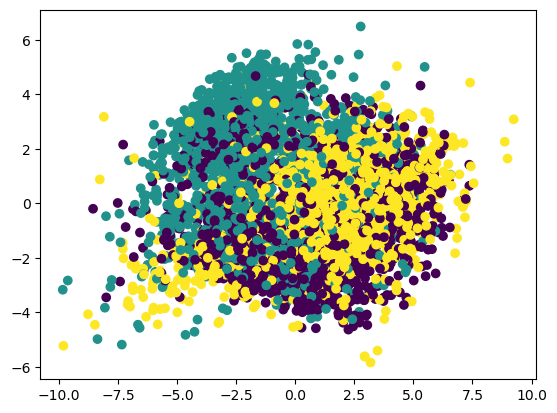

In [15]:
plt_scatter_dims12(X_train_pca, y_train)

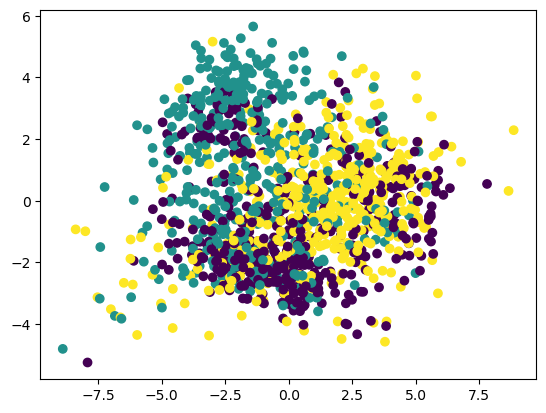

In [16]:
plt_scatter_dims12(X_val_pca, y_val)

Avec 2 variables, nous n'arrivons pas vraiment à séparer les 3 classes!

2 affichages suivants peuvent être ajoutés: Cercle de corrélations, eigenfaces.

Entrainer un classifieur sur le train, appliquer aux données de validation.



In [20]:
clf = SVC(C=1, kernel='linear', max_iter=50000, random_state=1)

start = time.time()
clf.fit(X_train_pca, y_train)
done = time.time()

elapsed = done - start
print(f'Training time on reduced data = {elapsed:.2f} sec \n\n')

print("Score on reduced data :", clf.score(X_val_pca, y_val))  # 0.67407


Training time on reduced data = 1.12 sec 


Score on reduced data : 0.6888888888888889


/home/alex/anaconda3/envs/DSTest_proj_env06/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [18]:
y_pred_val = clf.predict(X_val_pca)
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       462
           1       0.71      0.72      0.71       434
           2       0.65      0.66      0.65       454

    accuracy                           0.68      1350
   macro avg       0.69      0.68      0.68      1350
weighted avg       0.68      0.68      0.68      1350



In [19]:
# confusion matrix
pd.crosstab(y_val, y_pred_val)

col_0,0,1,2
group,,,
0,315,58,89
1,48,311,75
2,87,69,298


The results are not very high, but 2 times better than random guessing.